In [1]:
import pandas as pd
import numpy as np
import cv2
import pickle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Loading and Preparing Data 

In [4]:
df = pd.read_csv('F:\\Projects\\Emotion Detection\\Raw_Data/train.csv')

In [5]:
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
df.shape

(28709, 2)

In [7]:
labels = df['emotion']
labels.shape

(28709,)

In [13]:
train = []
i = 0
for arr in df['pixels']:
    num = []
    cut = arr.split(' ')
    for pix in cut:
        num.append(float(pix))
    train.append(np.array(num).reshape(48,48))
    i+=1

In [14]:
np.shape(train)

(28709, 48, 48)

### Preparing x and y

In [13]:
x = np.array(train).reshape((-1,48,48,1))
x = x/255

In [14]:
x.shape

(28709, 48, 48, 1)

In [9]:
y = to_categorical(labels)

In [10]:
y.shape

(28709, 7)

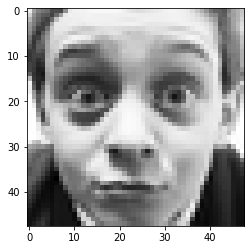

In [21]:
plt.imshow(train[1120],'gray')

In [27]:
labels[1120]

5

In [48]:
with open('F:\\Projects\\Emotion Detection\\Prepared_Data/feed_cv2.pickle','wb') as f:
    pickle.dump(x,f)

In [49]:
with open('F:\\Projects\\Emotion Detection\\Prepared_Data/label_cv2.pickle','wb') as f:
    pickle.dump(y,f)

In [32]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

### Model

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [33]:
def build_model():

    model = Sequential()

    model.add(Conv2D(64,(3,3),input_shape=(48,48,1),activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(64,(3,3),activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(128,(3,3),activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Conv2D(256,(3,3),activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(256,(3,3),activation='relu'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D((2,2)))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())

    model.add(Dropout(0.6))

    model.add(Dense(7,activation='softmax'))

    model.compile(metrics=['accuracy'],optimizer='adam',loss='categorical_crossentropy')

    model.summary()
    
    return model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 44, 44, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 20, 20, 32)        18464     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 18, 18, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 9, 64)         

In [34]:
model = build_model()
model.fit(x_train,y_train,epochs=100,
          verbose=1,
          validation_split=0.1,
          callbacks=callbacks,
          steps_per_epoch=len(X_train) / 32,
          use_multiprocessing=True
         )

Train on 19377 samples, validate on 2154 samples
Epoch 1/20
19377/19377 [==============================] - 10s 540us/step - loss: 1.7724 - accuracy: 0.2675 - val_loss: 1.6641 - val_accuracy: 0.3431
Epoch 2/20
19377/19377 [==============================] - 11s 585us/step - loss: 1.5612 - accuracy: 0.3825 - val_loss: 1.4269 - val_accuracy: 0.4327
Epoch 3/20
19377/19377 [==============================] - 10s 534us/step - loss: 1.4041 - accuracy: 0.4473 - val_loss: 1.3437 - val_accuracy: 0.4703
Epoch 4/20
19377/19377 [==============================] - 11s 557us/step - loss: 1.3151 - accuracy: 0.4888 - val_loss: 1.3045 - val_accuracy: 0.4935
Epoch 5/20
19377/19377 [==============================] - 11s 556us/step - loss: 1.2336 - accuracy: 0.5298 - val_loss: 1.2888 - val_accuracy: 0.5000
Epoch 6/20
19377/19377 [==============================] - 11s 562us/step - loss: 1.1651 - accuracy: 0.5548 - val_loss: 1.2811 - val_accuracy: 0.5084
Epoch 7/20
19377/19377 [==============================] -

In [35]:
model.save('D:\\Programming\\Python\\Neural Network\\Emotion Detection\\Model/FED-48x48x1-CNN_cv2.model')